<a href="https://colab.research.google.com/github/Kapernikov/cv_camera/blob/master/workshop_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependancies 

In [ ]:
!git clone https://github.com/Kapernikov/workshop-face-and-plate-recognition.git


In [ ]:
!pip install onnxruntime==1.14.1 opencv-python==4.7.0.*

In [27]:
import cv2
import numpy as np
import onnxruntime as ort

# Pre processing

In [31]:
def get_preprocessed_image(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (640, 480))
    img = (img - np.array([127, 127, 127])) / 128
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)

    return img

# Run the model

In [34]:
ort_session = ort.InferenceSession("""workshop-face-and-plate-recognition//models//ultra_light_640.onnx""")
input_name = ort_session.get_inputs()[0].name
def predict(input_data):
    confidences, boxes = ort_session.run(None, {input_name: input_data})
    return confidences, boxes

sample_data  workshop-face-and-plate-recognition


# Post processing

## Intersection-over-union

IOU is a metric that quantify the proportion of area that is shared by two surfaces.
Here, we will work with square that we will also call bounding box.

In [28]:
def get_area_of_rectangles(left_top_corners, right_bottom_corners):
    hw = np.clip(right_bottom_corners - left_top_corners, 0.0, None)
    return hw[..., 0] * hw[..., 1]

def get_IOU_of(ground_truth_boxes, uncertain_boxes):
    overlap_left_top = np.maximum(ground_truth_boxes[..., :2], uncertain_boxes[..., :2])
    overlap_right_bottom = np.minimum(ground_truth_boxes[..., 2:], uncertain_boxes[..., 2:])

    overlap_area = get_area_of_rectangles(overlap_left_top, overlap_right_bottom)
    area_ground_truth = get_area_of_rectangles(ground_truth_boxes[..., :2], ground_truth_boxes[..., 2:])
    area_prediction = get_area_of_rectangles(uncertain_boxes[..., :2], uncertain_boxes[..., 2:])
    return overlap_area / (area_ground_truth + area_prediction - overlap_area + 1e-5) # A small value is added to the denominator to avoid division per 0

## non-maximum-suppression

In [30]:
def get_indexes_of_best_boxes(box_scores, iou_threshold, candidate_size=200):
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = get_IOU_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]

    return box_scores[picked, :]

## post process model result


In [37]:
def get_areas_of_interest_lables_and_probability(width, height, confidences, boxes, prob_threshold, iou_threshold=0.5):
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = get_indexes_of_best_boxes(box_probs, iou_threshold=iou_threshold)
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]

# Blur area


In [35]:
def blur_box(frame, box):
    h, w, _ = frame.shape
    x1, y1, x2, y2 = box

    roi_buffer = max((x2-x1), (y2-y1))//4
    x1_buffered = max(0, x1-roi_buffer)
    y1_buffered = max(0, y1-roi_buffer)
    x2_buffered = min(w, x2+roi_buffer)
    y2_buffered = min(h, y2+roi_buffer)

    roi = frame[y1_buffered:y2_buffered, x1_buffered:x2_buffered]
    roi = cv2.resize(roi, (8, 8), interpolation=cv2.INTER_NEAREST)
    roi = cv2.resize(roi, (x2_buffered-x1_buffered, y2_buffered-y1_buffered), interpolation=cv2.INTER_NEAREST)
    frame[y1_buffered:y2_buffered, x1_buffered:x2_buffered] = roi

def draw_box(frame, box, label):
    h, w, _ = frame.shape
    x1, y1, x2, y2 = box

    roi_buffer = max((x2-x1), (y2-y1))//4
    x1_buffered = max(0, x1-roi_buffer)
    y1_buffered = max(0, y1-roi_buffer)
    x2_buffered = min(w, x2+roi_buffer)
    y2_buffered = min(h, y2+roi_buffer)

    cv2.rectangle(frame, (x1, y1), (x2, y2), (80,18,236), 2)
    cv2.rectangle(frame, (x1, y2 - 20), (x2, y2), (80,18,236), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = f"face: {label}"
    cv2.putText(frame, text, (x1 + 6, y2 - 6), font, 0.5, (255, 255, 255), 1)


# glue all together

--2023-03-15 16:02:50--  https://www.etonline.com/sites/default/files/images/2019-09/gettyimages-143479394.jpg
Resolving www.etonline.com (www.etonline.com)... 151.101.21.188
Connecting to www.etonline.com (www.etonline.com)|151.101.21.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712350 (696K) [image/jpeg]
Saving to: ‘example.webp’

example.webp        100%[===================>] 695.65K  --.-KB/s    in 0.03s   

2023-03-15 16:02:50 (19.9 MB/s) - ‘example.webp’ saved [712350/712350]



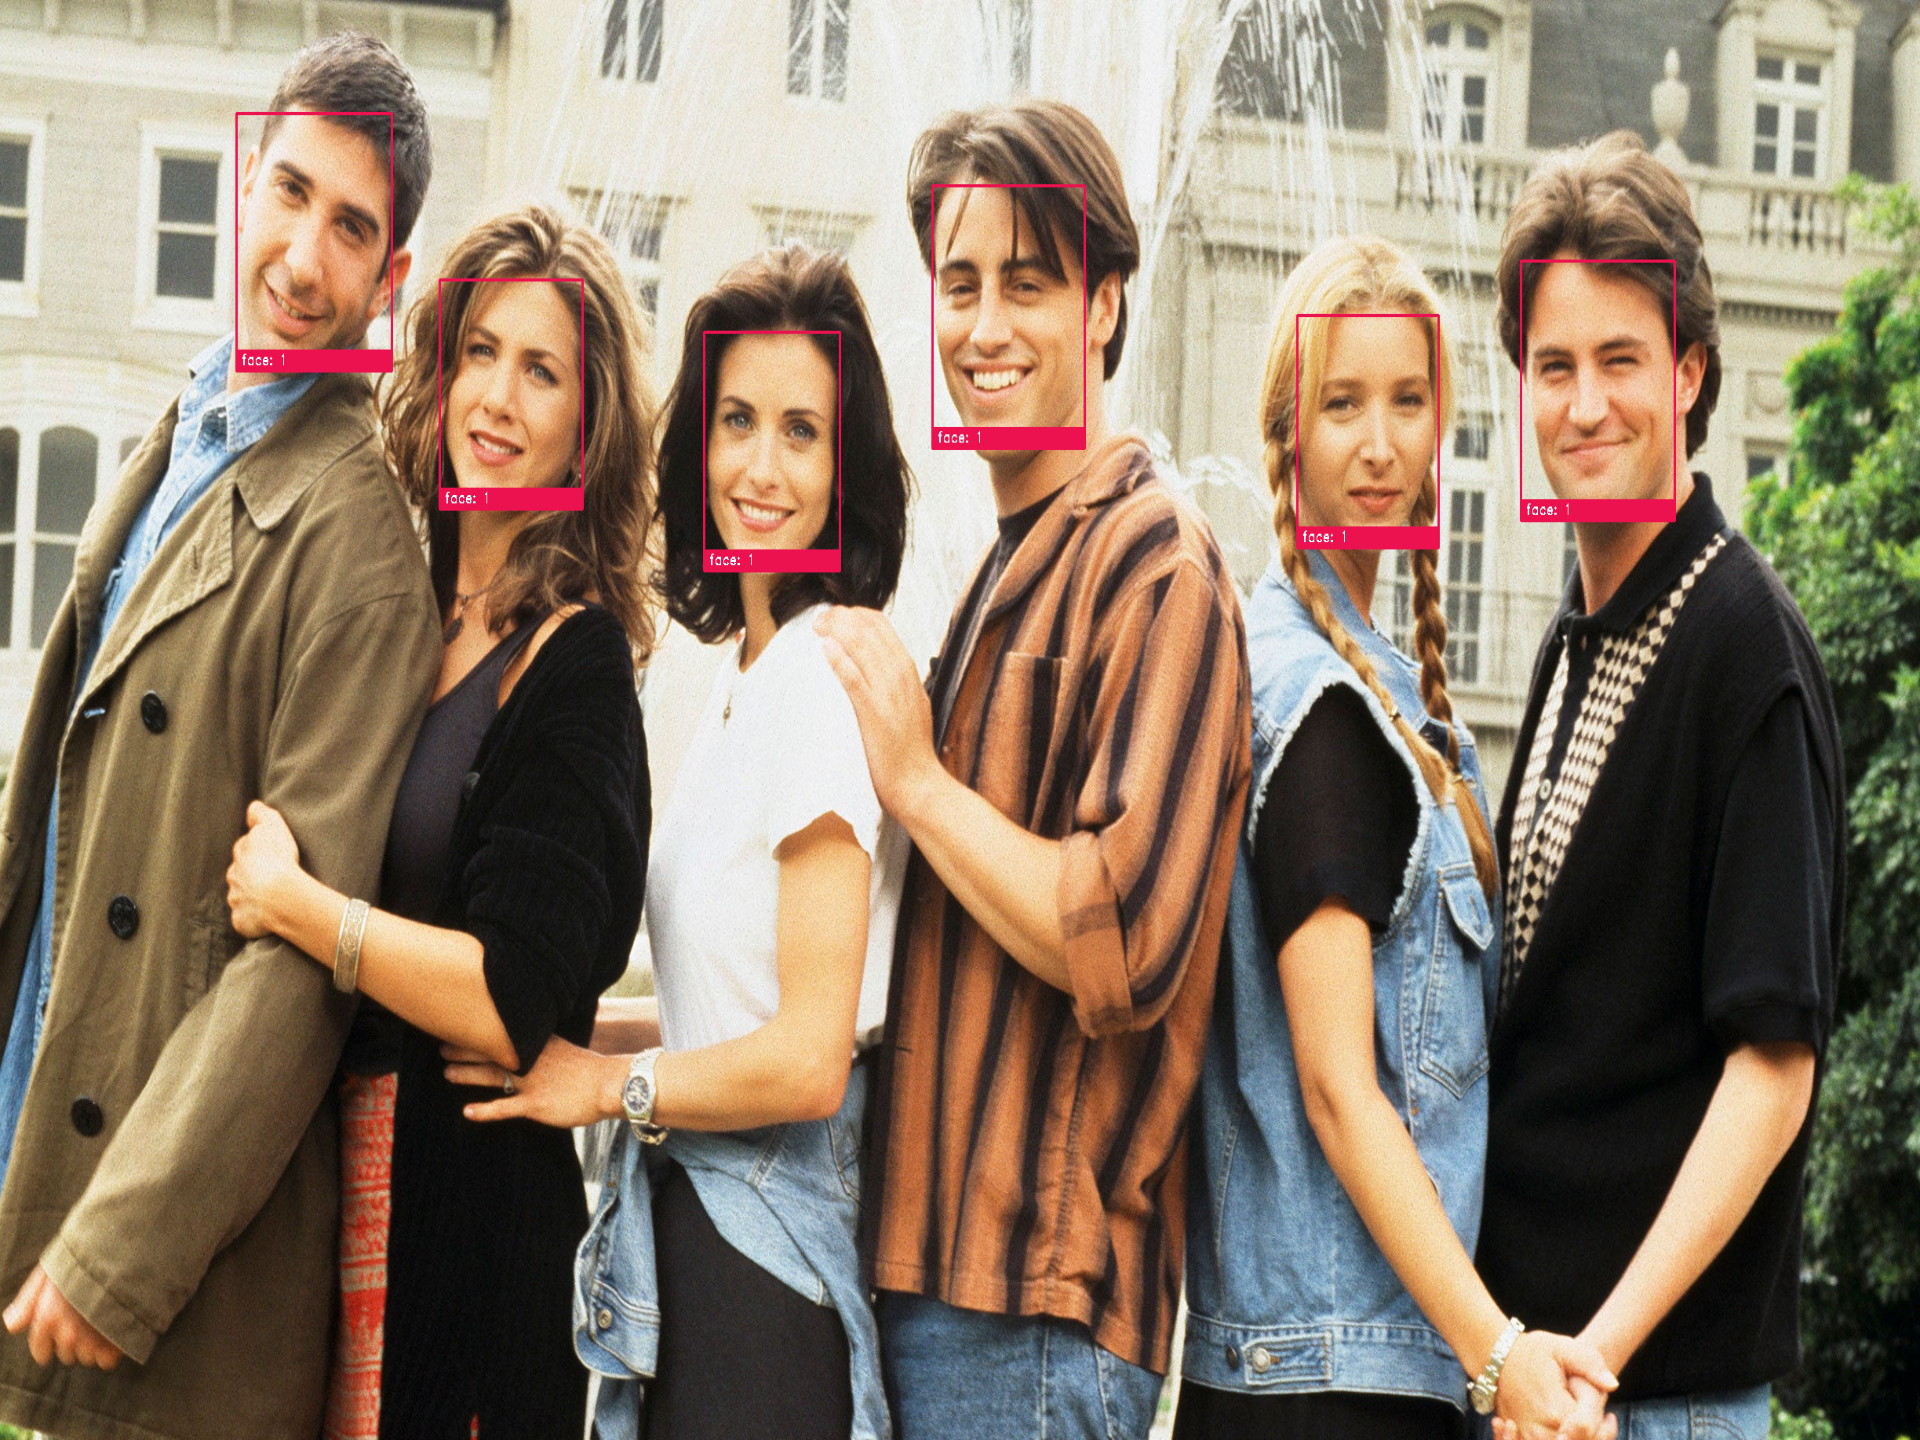

In [44]:
!wget -O example.webp https://www.etonline.com/sites/default/files/images/2019-09/gettyimages-143479394.jpg
file_name = '/content/example.webp'

video_capture = cv2.VideoCapture(file_name)
ret, frame = video_capture.read()

input_data = get_preprocessed_image(frame)

confidences, boxes = predict(input_data)

h, w, _ = frame.shape
boxes, labels, probs = get_areas_of_interest_lables_and_probability(w, h, confidences, boxes, 0.5)

for i in range(boxes.shape[0]):
    box = boxes[i, :]
    # blur_box(frame, box)
    draw_box(frame, box, labels[i])

# cv2.imshow('Video', frame)
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(frame, (640*3, 480*3)))


video_capture.release()